In [126]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches

# Switch to choose between Float64 and BigFloat
use_bigfloat = true


###########################################################################################
# Custom factorial
###########################################################################################

# Custom factorial function for BigFloat
function factorial_big(x::BigFloat)
    if x == BigFloat(0)
        return BigFloat(1.0)
    else
        return x * factorial_big(x - BigFloat(1))
    end
end

# Custom factorial function for Float64
function factorial_float(x::Float64)
    if x == 0.0
        return 1.0
    else
        return x * factorial_float(x - 1.0)
    end
end

# Factorial function based on switch
factorial(x) = use_bigfloat ? factorial_big(BigFloat(x)) : factorial_float(Float64(x))
###########################################################################################


# Set up the points with BigFloat or Float64
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)

# vertices
T1 = hcat(p1, p2, p3)
eval_T1(i, j) = T1[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T1[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(i, j) = T2[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T2[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# midpoint
T3 = hcat(b)
eval_T3(i, j) = T3[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T3[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

eval_T4(a, i, j) = T4(a)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T4(a)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, 
             a * m2 .+ (1 .- a) * p2, 
             a * m3 .+ (1 .- a) * p3)

eval_T5(a, i, j) = T5(a)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T5(a)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

eval_T6(a, b, i, j) = T6(a, b)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T6(a, b)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# Integral function using custom factorial
function integral(i, j)
    factorial(j) * factorial(i) / factorial(i + j + 2)
end

# System setup
function Aij(i, j, a)
    vcat(
        sum(eval_T1(i, j)), # trig vertices
        # eval_T2(i, j), # edge midpoints

        sum(eval_T4(a[1], i, j)), # edge class
        sum(eval_T4(a[2], i, j)), # edge class
        


        # eval_T3(i, j), # trig midpoint
        
        sum(eval_T5(a[3], i, j)),
        sum(eval_T5(a[4], i, j)),
        sum(eval_T5(a[5], i, j)),

        sum(eval_T6(a[6],a[7], i, j)),
        sum(eval_T5(a[8], i, j)),
        # sum(eval_T5(a[9], i, j)),
        )
end


# # System setup
# function Aij(i, j, a)
#     vcat(sum(eval_T1(i, j)),
#          sum(eval_T4(a[1], i, j)), # edge class
#          sum(eval_T5(a[2], i, j)),
#          sum(eval_T5(a[3], i, j)))
# end

A(a, order) = hcat([Aij(i, j, a) for i in 0:order for j in 0:order if i + j <= order]...)
rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)

rhs (generic function with 1 method)

In [127]:
freeparam = 8

order = 10
# f(a) = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order)
f(a) = norm(A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order))

f (generic function with 1 method)

BigFloat[0.6373474744165053408901632120258173941831795536003159198986783287241286721780398, 0.6806330859662282513934498921574871508264248917929143882088601717056386419812952, 0.2068505590112760159098266620504128286423113532224596336781062121817909016385784, 0.748826882375936087911451063502803379118670992200661007665550301243273523255084, 0.8123617354996680219322935062015599133118956768857834960331662467122870729951956, 0.6101890628698500947984874295513810119700431979132808966943607095756441083267418, 0.3100712855930542198346848644459229493127600613237381202746186393409688619726694, 0.5502011548083633597842762945387238457202360950289126080382443159319527659079085]

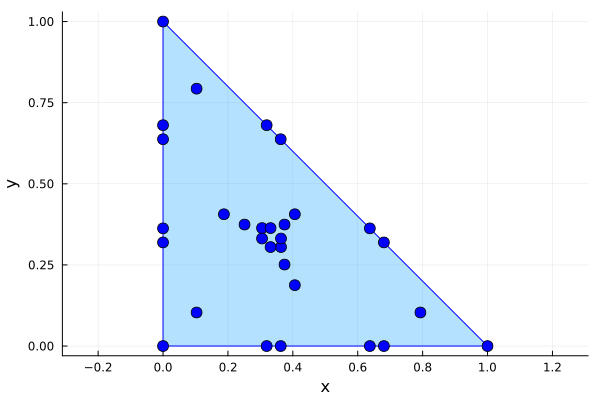

In [128]:
# Define the bounds
# lower_bounds = BigFloat[0.0, 0.0, 0.0]
# upper_bounds = BigFloat[1, 1, 1]
# initial_value = BigFloat[0.1, 0.1, 0.2]

min_val = 0.15
max_val = 0.85
a = min_val .+ (max_val - min_val) .* (use_bigfloat ? BigFloat.(rand(freeparam)) : rand(freeparam))

# a = BigFloat[0.01, 0.01, 0.02]
# a = BigFloat[0.1, 0.1, 0.2] # works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32] #works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32]

print(a)

#########################################################################################################################
# Plotting initial distribution
#########################################################################################################################
using Plots
plot()
# gr()  # Set the backend to GR

# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T3[1, :], T3[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 6, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")
#########################################################################################################################

In [129]:
# Initialize an array of strings
# bigfloat_strings = [
#     "0.3497563276590531286006952954445668121161354629231253675436650998033682105163362",
#     "0.1168256301165253085822263078463557402695806217250798718929824146309700850615156",
#     "0.5359920624522696018750290486301153617643693213794692184596278721041560647158745",
#     "0.9164715952736393185489606854094341672897032003628564147678514037992402493209116",
#     "0.1285678358785933850614611990426681246047116310691077189241495441532828989922064",
#     "0.1855704466508220428127271513465450386606911784968365895779597754013640528697462",
#     "0.1423596791302088104796922427088486702578148291092101059677756895056200393064595",
#     "0.7432798925094192858277743305767780573199273721370474792622147549960748094153323",
#     "0.2656623668160845723068798650918091304937794310308354680743438212151354872098177",
# ]
# print(a)
# Convert each string to BigFloat with full precision
# a = [parse(BigFloat, x) for x in bigfloat_strings]
# f(a)

# 0.435550025252798077216426997182572878840986513981683599296083745679164511699355
# 0.6637731214588893098777332609060568543103149065899114560422128146835452078278195
# 0.3264161593786625458414059141416173085535859770832105718160910797984164410934227
# 0.3238553555448429211620722851576776397156578278747866410510017646726121931521902
# 0.5240811779919137310112339080707195055864630881706360421103444401091930870961733
# 0.3802763277282470564714697017139324236356332292701035679786790042952726587088819
# 0.3395063654849585434670365174169452616756157045808562770409328931964232367590739

a

8-element Vector{BigFloat}:
 0.6373474744165053408901632120258173941831795536003159198986783287241286721780398
 0.6806330859662282513934498921574871508264248917929143882088601717056386419812952
 0.2068505590112760159098266620504128286423113532224596336781062121817909016385784
 0.748826882375936087911451063502803379118670992200661007665550301243273523255084
 0.8123617354996680219322935062015599133118956768857834960331662467122870729951956
 0.6101890628698500947984874295513810119700431979132808966943607095756441083267418
 0.3100712855930542198346848644459229493127600613237381202746186393409688619726694
 0.5502011548083633597842762945387238457202360950289126080382443159319527659079085

In [130]:
# println(a)

# td = TwiceDifferentiable(f, a; autodiff = :forward);

# # result = optimize(td, a, Newton(; linesearch = LineSearches.MoreThuente()), Optim.Options(g_tol = 1e-100, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))
# # result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-15, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))

# result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-63, iterations = 50, show_trace = true, show_every = 10, time_limit = 1000))

# println(result)

# a = Optim.minimizer(result)
# using Base.Threads

# using Distributed

# num_runs = 5

# @threads  for i in 1:num_runs
# a = min_val .+ (max_val - min_val) .* BigFloat.(rand(freeparam))

td = TwiceDifferentiable(f, a; autodiff = :forward)
method = Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic())
options = Optim.Options(g_tol = 1e-15, iterations = 1000, show_trace = true, show_every = 10, time_limit = 1000)

result = optimize(td, a, method, options)
a = Optim.minimizer(result)
# end

print(a)

Iter     Function value   Gradient norm 
     0     1.359433e-05     4.062794e-04
 * time: 0.0
    10     4.228311e-07     7.268947e-05
 * time: 16.918999910354614
    20     3.094514e-07     7.580687e-06
 * time: 33.091999769210815


In [ ]:
result

In [ ]:
# result2 = optimize(f,
#             a,
#             NelderMead(),
#             autodiff = :forward,
#             Optim.Options(g_tol = 1e-63, iterations = 1000, show_trace = true, show_every = 100, time_limit = 1000))

In [ ]:
a = Optim.minimizer(result)

In [ ]:
(A(a,order) * A(a,order)')\(A(a,order) * rhs(order))

In [ ]:
f(a)

In [ ]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T3[1, :], T3[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T5(a[8])[1, :], T5(a[8])[2, :], markersize = 5, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

# savefig("kek.png")

In [ ]:
println(T1)

println(T4(a[1]))
println(T4(a[2]))

println(T5(a[3]))
println(T5(a[4]))
println(T5(a[5]))

In [ ]:
integral(1,8)